In [1]:
!pip install labelme

     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---------------------- ----------------- 0.8/1.4 MB 25.4 MB/s eta 0:00:01
     ---------------------------------------  1.4/1.4 MB 22.8 MB/s eta 0:00:01
     ---------------------------------------- 1.4/1.4 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
     ----- ---------------------------------- 1.0/7.7 MB 32.7 MB/s eta 0:00:01
     -------------- ------------------------- 2.8/7.7 MB 29.5 MB/s eta 0:00:01
     ----------------------- ---------------- 4.5/7.7 MB 31.8 MB/s eta 0:00:01
     -------------------------------- ------- 6.2/7.7 MB 33.2 MB/s eta 0:00:01
     ---------------------------------------  7.7/7.7 MB 35.0 MB/s eta 0:00:01
     ---------------------------------------- 7.7/7.7 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Pr

# Collect the images using opencv

In [1]:
import os
import time
import uuid
import cv2

In [2]:
uuid.uuid1()

UUID('db666a87-aa8a-11ee-8a3d-18568057f99e')

In [7]:
!mkdir data\images

In [8]:
!mkdir data\labels

In [3]:
IMAGES_PATH = os.path.join("data", "images")
number_images = 30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print(f"Collecting image {imgnum}")
    # the ret means whether it successfully capture something
    # frame means the image in the video
    ret, frame = cap.read()
    if ret:
        imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg")
        # save the image into the directory
        cv2.imwrite(imgname, frame)
        cv2.imshow("frame", frame)
        
    # to pause 0.5 sec while collecting each image
    time.sleep(0.5)

    # when the "Q" is pressed, exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Annotate the images with LabelMe

In [6]:
!labelme

2024-01-04 06:55:28,007 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\yihim\.labelmerc


# Review the images

In [7]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [10]:
images = tf.data.Dataset.list_files("data/images/*.jpg", shuffle=False)

In [12]:
images.as_numpy_iterator().next()

b'data\\images\\42ca7bc5-aa89-11ee-884c-18568057f99e.jpg'

In [13]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [14]:
images = images.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
images.as_numpy_iterator().next()

array([[[113, 120,  87],
        [113, 120,  89],
        [113, 118,  96],
        ...,
        [132, 135, 106],
        [130, 134, 107],
        [128, 132, 105]],

       [[113, 120,  87],
        [113, 119,  91],
        [113, 118,  96],
        ...,
        [135, 138, 109],
        [134, 138, 111],
        [133, 137, 110]],

       [[115, 122,  91],
        [114, 120,  92],
        [114, 119,  97],
        ...,
        [136, 139, 110],
        [136, 141, 111],
        [135, 140, 110]],

       ...,

       [[ 79,  69,  34],
        [ 80,  72,  36],
        [ 73,  69,  31],
        ...,
        [152, 120,  79],
        [158, 125,  84],
        [160, 128,  87]],

       [[ 77,  66,  34],
        [ 69,  61,  25],
        [ 52,  47,   9],
        ...,
        [160, 127,  84],
        [161, 126,  86],
        [160, 127,  86]],

       [[ 73,  62,  30],
        [ 69,  61,  25],
        [ 55,  50,  12],
        ...,
        [162, 128,  83],
        [161, 126,  86],
        [158, 123,  83]]

In [16]:
type(images)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

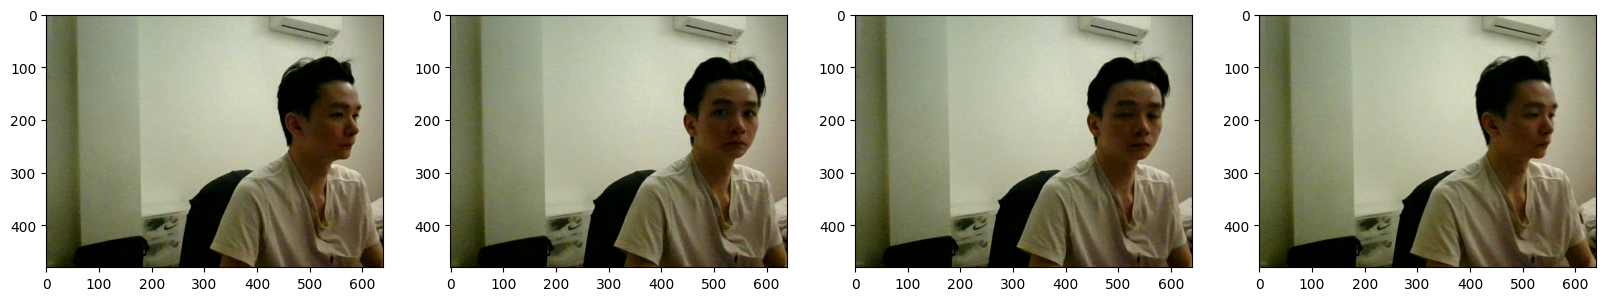

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)

plt.show()

# Partition Unaugmented Data

In [24]:
!mkdir data\train
!mkdir data\train\images
!mkdir data\train\labels
!mkdir data\test
!mkdir data\test\images
!mkdir data\test\labels
!mkdir data\val
!mkdir data\val\images
!mkdir data\val\labels

In [25]:
total_imgs = 0
for i in os.listdir("data/images/"):
    total_imgs += 1

In [26]:
total_imgs

94

In [31]:
train_split = int(total_imgs * 0.7)
val_split = int((total_imgs - train_split)/2) + 1
test_split = int((total_imgs - train_split)/2)

In [32]:
train_split, val_split, test_split

(65, 15, 14)

In [35]:
import shutil
import random

In [36]:
train_img_path = "data/train/images/"
val_img_path = "data/val/images/"
test_img_path = "data/test/images/"
src_img_path = "data/images/"

In [37]:
all_images = os.listdir(src_img_path)

selected_train_imgaes = random.sample(all_images, train_split)

for img in selected_train_imgaes:
    src_path = os.path.join(src_img_path, img)
    dest_path = os.path.join(train_img_path, img)

    shutil.move(src_path, dest_path)

all_images = os.listdir(src_img_path)

selected_val_imgaes = random.sample(all_images, val_split)

for img in selected_val_imgaes:
    src_path = os.path.join(src_img_path, img)
    dest_path = os.path.join(val_img_path, img)

    shutil.move(src_path, dest_path)

all_images = os.listdir(src_img_path)

for img in all_images:
    src_path = os.path.join(src_img_path, img)
    dest_path = os.path.join(test_img_path, img)

    shutil.move(src_path, dest_path)

# To move the corresponding labels to the images that are in the train, test and val folders

In [38]:
for folder in ["train", "test", "val"]:
    for file in os.listdir(os.path.join("data", folder, "images")):
        filename = file.split(".")[0]+".json"
        existing_filepath = os.path.join("data", "labels", filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join("data", folder, "labels", filename)
            os.replace(existing_filepath, new_filepath)

# Perform augmentation

In [40]:
import albumentations as alb

In [41]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomGamma(p=0.2),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format="albumentations", # the format is crucial, go to the website to look up
                                                   label_fields=["class_labels"]))

In [42]:
img = cv2.imread("data/train/images/42ca7bc5-aa89-11ee-884c-18568057f99e.jpg")

In [43]:
with open("data/train/labels/42ca7bc5-aa89-11ee-884c-18568057f99e.json", "r") as f:
    label = json.load(f)

In [47]:
label["shapes"][0]["points"]

[[448.4810126582279, 119.43037974683548],
 [595.3164556962025, 286.5189873417721]]

In [61]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [62]:
coords
# x1, y1, x2, y2
# top coord, bot coord
# xmin, ymin, xmax, ymax

[448.4810126582279, 119.43037974683548, 595.3164556962025, 286.5189873417721]

In [63]:
# to normalize it by dividing the original image width and height
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [64]:
coords

[0.7007515822784811,
 0.24881329113924058,
 0.9301819620253164,
 0.5969145569620252]

# Apply augmentation

In [65]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])

In [66]:
# returns a dict
augmented

{'image': array([[[  0,   4,   0],
         [  0,   4,   0],
         [  0,   4,   0],
         ...,
         [  5,  42,  70],
         [  2,  46,  77],
         [  0,  45,  76]],
 
        [[  0,   4,   0],
         [  0,   4,   0],
         [  0,   4,   0],
         ...,
         [  6,  43,  69],
         [  0,  43,  72],
         [  0,  42,  70]],
 
        [[  0,   4,   0],
         [  0,   4,   0],
         [  0,   2,   0],
         ...,
         [  7,  45,  69],
         [  4,  45,  70],
         [  0,  45,  72]],
 
        ...,
 
        [[146, 164, 151],
         [145, 163, 150],
         [147, 164, 151],
         ...,
         [133, 154, 152],
         [131, 152, 150],
         [131, 151, 152]],
 
        [[145, 163, 150],
         [147, 164, 151],
         [150, 164, 152],
         ...,
         [133, 153, 154],
         [133, 153, 154],
         [131, 150, 153]],
 
        [[144, 162, 149],
         [147, 164, 151],
         [151, 165, 153],
         ...,
         [129, 149,

In [67]:
augmented["bboxes"][0][:2]

(0.6321800281293953, 0.38551336146272863)

In [68]:
augmented["bboxes"][0][2:]

(0.9584810126582278, 0.7568213783403656)

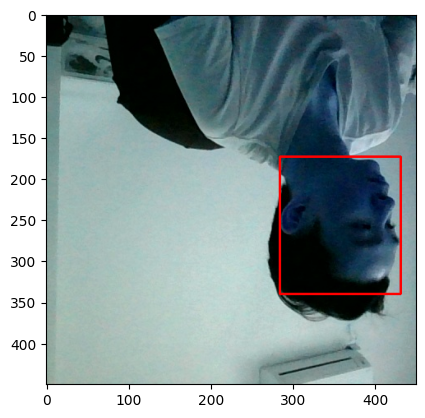

In [69]:
cv2.rectangle(augmented["image"],
              tuple(np.multiply(augmented["bboxes"][0][:2], [450, 450]).astype(int)), # top coords
              tuple(np.multiply(augmented["bboxes"][0][2:], [450, 450]).astype(int)), # bot coords
              (255,0,0),
              2)

plt.imshow(augmented["image"])

# Build and run the augmentation pipeline

In [70]:
!mkdir aug_data

In [71]:
!mkdir aug_data\train
!mkdir aug_data\train\images
!mkdir aug_data\train\labels
!mkdir aug_data\test
!mkdir aug_data\test\images
!mkdir aug_data\test\labels
!mkdir aug_data\val
!mkdir aug_data\val\images
!mkdir aug_data\val\labels

In [73]:
for partition in ["train", "test", "val"]:
    for image in os.listdir(os.path.join("data", partition, "images")):
        img = cv2.imread(os.path.join("data", partition, "images", image))

        # by setting this is also for the images that do not contain faces
        # if contain faces, then normalize
        # if does not, then just remain this in order to perform the augmentation as well,
        # which required coords for the bbox
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join("data", partition, "labels", f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)

            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
                cv2.imwrite(os.path.join("aug_data", partition, "images", f"{image.split('.')[0]}.{x}.jpg"), 
                            augmented["image"])

                annotation = {}
                annotation["image"] = image

                # this is to check whether the image contain face or not
                # if does, then store the values
                # if not, then store 0
                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0:
                        annotation["bbox"] = [0,0,0,0]
                        annotation["class"] = 0
                    else:
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else:
                    annotation["bbox"] = [0,0,0,0]
                    annotation["class"] = 0

                with open(os.path.join("aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
                    json.dump(annotation, f)
                    
        except Exception as e:
            print(e)

# Prepare image dataset

In [74]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255.)

In [75]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255.)

In [76]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255.)

In [77]:
train_images.as_numpy_iterator().next()

array([[[0.38713235, 0.4072304 , 0.29546568],
        [0.37996325, 0.41752452, 0.29123774],
        [0.34675246, 0.40165442, 0.26930147],
        ...,
        [0.5579044 , 0.58143383, 0.47457108],
        [0.56740195, 0.5830882 , 0.48443627],
        [0.56170344, 0.5773897 , 0.47935048]],

       [[0.39442402, 0.41942403, 0.28547794],
        [0.36041668, 0.39963236, 0.2624387 ],
        [0.3560049 , 0.40257353, 0.26237744],
        ...,
        [0.26102942, 0.27236518, 0.20612745],
        [0.5155637 , 0.5307598 , 0.44154412],
        [0.56213236, 0.57254905, 0.48204657]],

       [[0.38535538, 0.4103554 , 0.2721201 ],
        [0.36844364, 0.396875  , 0.2684436 ],
        [0.36881128, 0.4041054 , 0.28253677],
        ...,
        [0.57990193, 0.5882353 , 0.53186274],
        [0.46439952, 0.47273284, 0.3903799 ],
        [0.25876224, 0.25925246, 0.17248775]],

       ...,

       [[0.16470589, 0.18921569, 0.02169118],
        [0.13339461, 0.15153186, 0.        ],
        [0.13829657, 0

# Prepare label dataset

In [79]:
def load_lbl(x):
    with open(x.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
    return [label["class"]], label["bbox"]

In [81]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_lbl, [x], [tf.uint8, tf.float16]))

In [82]:
val_labels = tf.data.Dataset.list_files("aug_data/val/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_lbl, [x], [tf.uint8, tf.float16]))

In [83]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_lbl, [x], [tf.uint8, tf.float16]))

In [84]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.93  , 0.221 , 1.    , 0.5923], dtype=float16))

# Combine image and label dataset

In [85]:
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(3900, 3900, 900, 900, 840, 840)

In [86]:
train_dataset = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.zip((val_images, val_labels)).shuffle(1300).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

In [87]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [88]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [89]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [94]:
train_dataset.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.4846, 0.309 , 0.7363, 0.5933],
        [0.1761, 0.2507, 0.4617, 0.5547],
        [0.    , 0.3906, 0.1567, 0.547 ],
        [0.693 , 0.287 , 0.995 , 0.6035],
        [0.    , 0.    , 0.    , 0.    ],
        [0.247 , 0.3413, 0.548 , 0.6636],
        [0.8486, 0.5605, 1.    , 0.801 ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

# Visualize the images and annotations

In [95]:
data_samples = train_dataset.as_numpy_iterator()

In [110]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


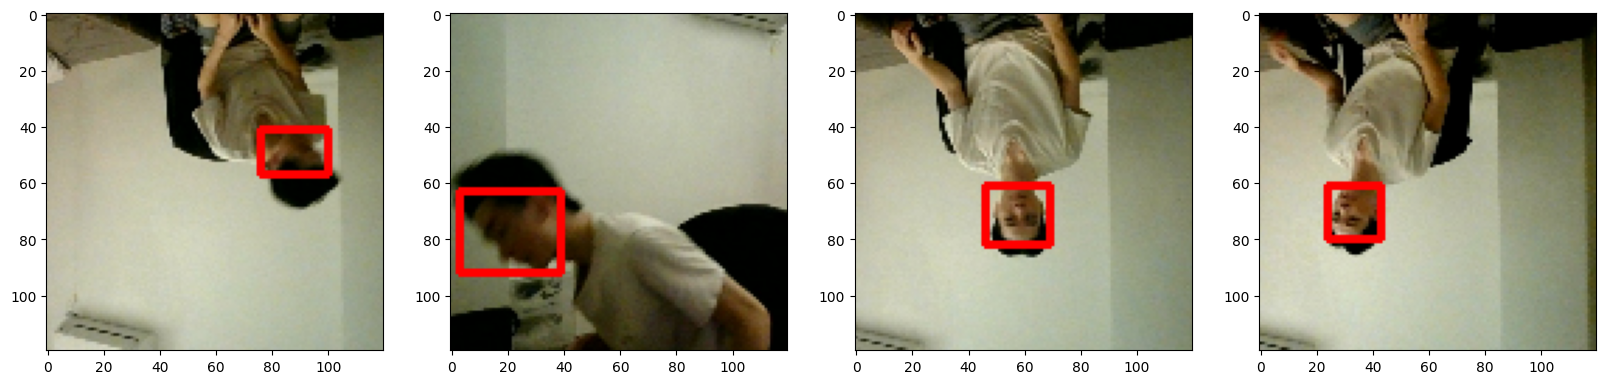

In [111]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = np.array(res[0][idx])
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0),
                  2)

    ax[idx].imshow(sample_image)

# Building the model

In [117]:
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [120]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 4s 0us/step


In [121]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [190]:
def build_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    input_layer = layers.Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = layers.GlobalMaxPool2D()(vgg)
    class1 = layers.Dense(2048, activation="relu")(f1)
    class2 = layers.Dense(1, activation="sigmoid")(class1)

    f2 = layers.GlobalMaxPool2D()(vgg)
    regress1 = layers.Dense(2048, activation="relu")(f2)
    regress2 = layers.Dense(4, activation="sigmoid")(regress1)

    model = tf.keras.Model(inputs=input_layer, outputs=[class2, regress2])
    return model

In [191]:
model = build_model()

In [192]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [130]:
X, y = train_dataset.as_numpy_iterator().next()

In [131]:
X.shape, y[0].shape, y[1].shape

((8, 120, 120, 3), (8, 1), (8, 4))

In [132]:
classes, coords = model.predict(X)

In [133]:
classes, coords

(array([[0.40930653],
        [0.5651253 ],
        [0.5620323 ],
        [0.5654632 ],
        [0.567381  ],
        [0.62462145],
        [0.5845462 ],
        [0.5240389 ]], dtype=float32),
 array([[0.50835145, 0.536895  , 0.42458472, 0.26416445],
        [0.45464256, 0.59647787, 0.48272175, 0.32230812],
        [0.42888367, 0.54738617, 0.4106603 , 0.30479467],
        [0.45116284, 0.5772601 , 0.5020065 , 0.26160133],
        [0.46523914, 0.55800736, 0.49737763, 0.26664937],
        [0.3362167 , 0.54273176, 0.41096154, 0.28885558],
        [0.44291523, 0.5626354 , 0.5092181 , 0.43529615],
        [0.37201712, 0.5254349 , 0.4588014 , 0.38334787]], dtype=float32))

In [149]:
batches_per_epoch = len(train_dataset)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [150]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

# Loss function

In [137]:
def localization_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [138]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [140]:
localization_loss(y[1], coords).numpy()

4.1216273

In [141]:
classloss(y[0], classes).numpy()

0.5579891

# Train the neural network

In [193]:
class FD_Model(tf.keras.models.Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    # during training, the data is fed in batch
    def train_step(self, batch, **kwargs):
        # unbatch the data
        X, y = batch

        with tf.GradientTape() as tape:
            # this is where the model try to predict the training data to obtain the loss
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            # here changing to float32 is because due to a mistake previously when defining the dataset, 
            # it is set to float16
            # changing to float32 just to ensure the loss function works smoothly
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    # this is to initiate the predict
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [194]:
fd_model = FD_Model(model)

In [195]:
fd_model.compile(opt=optimizer, classloss=classloss, localizationloss=regressloss)

In [153]:
import datetime

In [179]:
def tensorboard_cb(dirpath, model_name):
    return tf.keras.callbacks.TensorBoard(os.path.join(dirpath, 
                                                       model_name, 
                                                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

def checkpoint_cb(dirpath, model_name, save_format=None, save_weights=False):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(dirpath, model_name + save_format), 
                                              save_best_only=True, 
                                              save_weights_only=save_weights,
                                              monitor="total_loss",
                                              verbose=1)

def early_stopping_cb(patience):
    return tf.keras.callbacks.EarlyStopping(monitor="total_loss", 
                                            restore_best_weights=True, 
                                            patience=patience,
                                            verbose=1)

In [147]:
LOGS_PATH = "model_logs/"

In [196]:
fd_model_history = fd_model.fit(train_dataset, 
                                validation_data=val_dataset,
                                epochs=40,
                                callbacks=[tensorboard_cb(LOGS_PATH, "model_vgg16"),
                                           checkpoint_cb("", "model_vgg16_weights", save_format=".h5", save_weights=True),
                                           early_stopping_cb(5)])

Epoch 1/40
488/488 [==============================] - ETA: 0s - total_loss: 0.4182 - class_loss: 0.1880 - regress_loss: 0.3242
Epoch 1: total_loss improved from inf to 0.00720, saving model to model_vgg16_weights.h5
488/488 [==============================] - 62s 105ms/step - total_loss: 0.4174 - class_loss: 0.1876 - regress_loss: 0.3236 - val_total_loss: 0.0170 - val_class_loss: 0.0069 - val_regress_loss: 0.0135
Epoch 2/40
488/488 [==============================] - ETA: 0s - total_loss: 0.0512 - class_loss: 0.0145 - regress_loss: 0.0440
Epoch 2: total_loss improved from 0.00720 to 0.00105, saving model to model_vgg16_weights.h5
488/488 [==============================] - 80s 149ms/step - total_loss: 0.0511 - class_loss: 0.0144 - regress_loss: 0.0439 - val_total_loss: 0.0239 - val_class_loss: 6.4364e-04 - val_regress_loss: 0.0236
Epoch 3/40
488/488 [==============================] - ETA: 0s - total_loss: 0.0128 - class_loss: 0.0017 - regress_loss: 0.0120
Epoch 3: total_loss improved from

In [242]:
import pandas as pd

<Axes: >

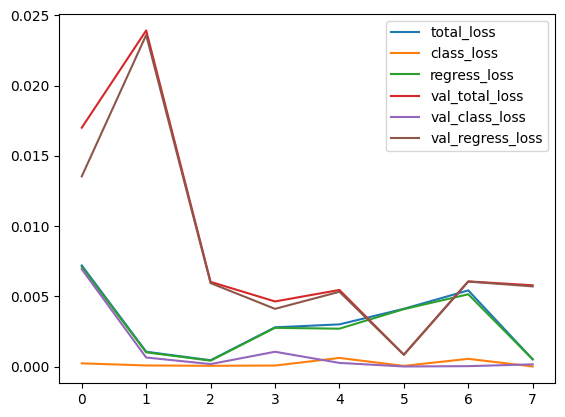

In [244]:
pd.DataFrame(fd_model_history.history).plot()

# Testing the model

In [197]:
test_data = test_dataset.as_numpy_iterator()

In [237]:
test_samples = test_data.next()

In [238]:
y_preds = fd_model.predict(test_samples[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


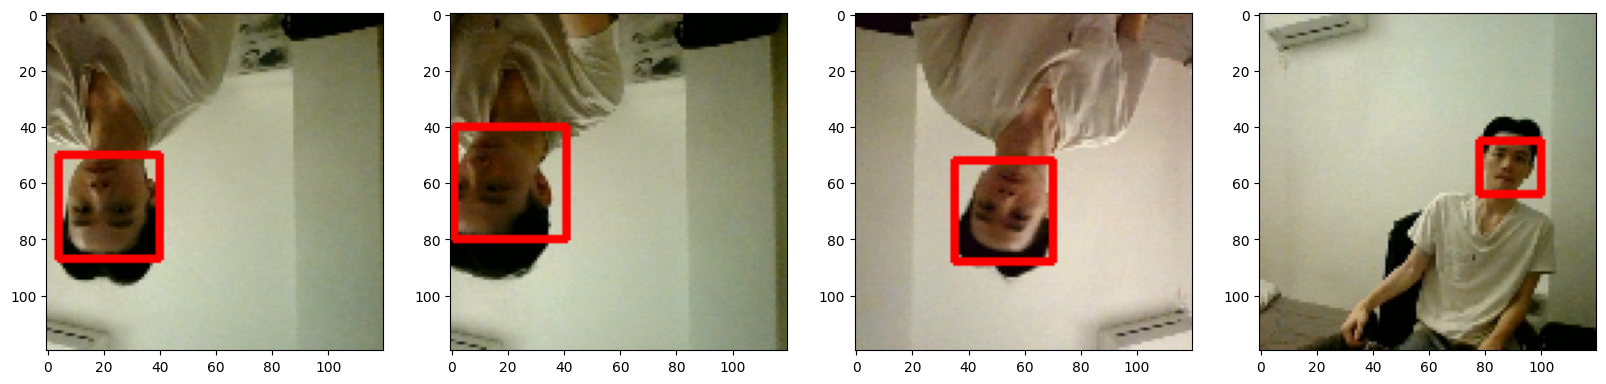

In [239]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = np.array(test_samples[0][idx])
    sample_coords = y_preds[1][idx]

    if y_preds[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0),
                      2)
        
    ax[idx].imshow(sample_image)

# Save the model

In [246]:
fd_model.save("model_vgg16")

INFO:tensorflow:Assets written to: model_vgg16\assets


In [247]:
fd_model_loaded = tf.keras.models.load_model("model_vgg16")

# Real time face detection

In [254]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    # here is setting the frame to 450 W, 450 H pixels
    frame = frame[50:500, 50:500, :]

    # convert from bgr to rgb due to opencv reads in bgr
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # resize the rgb to 120, 120 which compatible with the model for prediction
    resized = tf.image.resize(rgb, (120, 120))
    # as well as adding the batch and rescaling before predicting
    pred = fd_model_loaded.predict(np.expand_dims(resized/255., axis=0))
    # here is to get the predicted coords which is predicting for one image
    sample_coords = pred[1][0]

    # here is to get whether a face is being detected or not over a threshold which is also predicting for one image
    if pred[0] > 0.5:
        # controls the main bounding box
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255,0,0),
                      2)

        # controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [80, 0])),
                      (255,0,0),
                      -1)

        # this is to put the label on the bounding box
        cv2.putText(frame, "face", tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow("Face Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()